In [1]:
'''Since all the Dependency Heads, the Dependency Labels, and the Linearized Constituency Trees are generated in batches of 10000,
we need to concatenate those files.'''

import shutil
import glob
from natsort import natsorted

def concatenate_files(target_files, output_file):
    with open(output_file, 'wb') as outfile:
        for filename in natsorted(glob.glob(target_files)): # natsorted is used to sort the files in a natural way
            if filename == output_file:
                # don't want to copy the output into the output
                continue
            with open(filename, 'rb') as read_file:
                shutil.copyfileobj(read_file, outfile)

# for the dependency heads
target_files = '../models/questions/parsed/dependency_heads/*.txt'
output_file = '../models/questions/parsed/dependency_heads.txt'
concatenate_files(target_files, output_file)

# for the dependency labels
target_files = '../models/questions/parsed/dependency_labels/*.txt'
output_file = '../models/questions/parsed/dependency_labels.txt'
concatenate_files(target_files, output_file)

# for the linearized constituency trees
target_files = '../models/questions/parsed/linearized_constituency_tree/*.txt'
output_file = '../models/questions/parsed/linearized_constituency_tree.txt'
concatenate_files(target_files, output_file)


In [2]:
'''Here we read the Dependency Heads'''
from pathlib import Path
import ast

with open('../models/questions/parsed/dependency_heads.txt', 'r') as f:
    dep_head_list = f.readlines()

dep_head_list = [element.strip() for element in dep_head_list]
dep_head_list = [ast.literal_eval(element) for element in dep_head_list]

dep_head_list[0]


[2, 6, 6, 6, 6, 0]

In [3]:
with open('../models/questions/parsed/dependency_labels.txt', 'r') as f:
    dep_label_list = f.readlines()

dep_label_list = [element.strip() for element in dep_label_list]
dep_label_list = [ast.literal_eval(element) for element in dep_label_list]

dep_label_list[0]


['det', 'dep', 'cop', 'det', 'amod', 'nsubj']

In [4]:
'''Formulate the adjacency list based on the dependency heads and save it to a file'''
import json

adj_list = []
for element in dep_head_list:
    adj_list_element = []
    for index in element:
        adj_list_node = len(element)*[0]
        if index != 0:
            adj_list_node[index-1] = 1
        adj_list_element.append(adj_list_node)

    adj_list.append(adj_list_element)

with open("../models/questions/graphs/init_adj_list.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(adj_list, f, indent=2) 

'''Displaying the first adjacency matrix'''
with open("../models/questions/graphs/init_adj_list.json", 'r') as f:
    loaded_adj_list = json.load(f)

loaded_adj_list[0]

[[0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0]]

In [5]:
'''Also formulate the edge list if needed based on the dependency heads'''
edge_list = []
for element in dep_head_list:
    edge_list_element = []
    for index in range(len(element)):
        if element[index] != 0:
            edge_list_element.append([index, element[index]-1])
    edge_list.append(edge_list_element)

with open("../models/questions/graphs/init_edge_list.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(edge_list, f, indent=2) 

'''Displaying the first edge list'''
with open("../models/questions/graphs/init_edge_list.json", 'r') as f:
    loaded_edge_list = json.load(f)

print(loaded_edge_list[0])

[[0, 1], [1, 5], [2, 5], [3, 5], [4, 5]]


In [6]:
import torch
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
import numpy as np

# load questions
questions = json.load(open('../data/v1.0/visdial_1.0_train.json'))['data']['questions']

tokenizer = get_tokenizer("basic_english") # use basic_english tokenizer
tokenizer(questions[0])

['what', 'color', 'is', 'the', 'middle', 'vase']

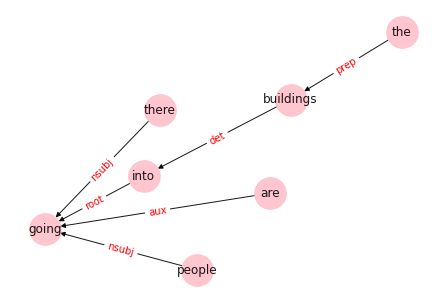

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

def pruned_question_graph(question_index):
    G = nx.DiGraph()

    label_mappings = dict(zip(list(range(len(
        tokenizer(questions[question_index])))), tokenizer(questions[question_index])))
    edge_mappings = dict(
        zip(list(map(tuple, edge_list[question_index])), dep_label_list[question_index]))

    G.add_edges_from(edge_list[question_index])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, labels=label_mappings, edge_color='black', width=1,
            linewidths=1, node_size=1000, node_color='pink', alpha=0.9, with_labels=True)
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_mappings, font_color='red')
    plt.axis('off')
    plt.show()


pruned_question_graph(1)


Graph Attention:

s_{ij}=\frac{(U_{i}u_{i})^{T}.V_{j}u_{j}}{\sqrt{d_{u}}}

